In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import string
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import unicodedata

# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('indonesian')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

In [ ]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    # text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    # text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/dataset/extractive.csv', usecols=['review_cln', 'abstractive'])
# data['abstractive'] = data['abstractive'].apply(clean_text)

In [ ]:
df = pd.DataFrame(columns=["review", "summary"])

In [ ]:
df['review'] = data['review_cln']
df['summary'] = data['abstractive']

In [ ]:
df['summary'] = [x.lower() for x in df['summary']]

In [ ]:
df

In [ ]:
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
USE_CUDA = True

In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sos ' + x + ' eos')

In [ ]:
df['summary']

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['review']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)
# x_tr = np.array(train_df['review'])
# x_val = np.array(val_df['review'])
# y_tr = np.array(train_df['summary'])
# y_val = np.array(val_df['summary'])

In [ ]:
# len(train_df), len(test_df), len(val_df)

In [ ]:
pre_data = pd.DataFrame()
pre_data['cleaned_text'] = pd.Series(df['review'])
pre_data['cleaned_summary'] = pd.Series(df['summary'])

In [ ]:
text_count = []
summary_count = []

In [ ]:
for sent in pre_data['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre_data['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [ ]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

In [ ]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [ ]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text

max_text_len=512
max_summary_len=82

In [ ]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras_preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=1

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(oov_token='oov', num_words=(tot_cnt-cnt)+1) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=1

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(oov_token='oov', num_words=(tot_cnt-cnt)+1) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

In [ ]:
x_voc

In [ ]:
y_tokenizer.word_index

In [ ]:
!pip install fasttext
import fasttext.util

In [ ]:
fasttext.util.download_model('id', if_exists='ignore')

In [ ]:
ft = fasttext.load_model('cc.id.300.bin')

In [ ]:
ft.get_word_vector('makan')

In [95]:
x_tokenizer.word_index

{'oov': 1,
 'dan': 2,
 'yang': 3,
 'di': 4,
 'saya': 5,
 'untuk': 6,
 'dengan': 7,
 'sangat': 8,
 'juga': 9,
 'ini': 10,
 'yg': 11,
 'hotel': 12,
 'ada': 13,
 'nya': 14,
 'ke': 15,
 'tidak': 16,
 'bisa': 17,
 'dari': 18,
 'tempat': 19,
 'kamar': 20,
 'kami': 21,
 'banyak': 22,
 'enak': 23,
 'karena': 24,
 'kita': 25,
 'makanan': 26,
 'ramah': 27,
 'cukup': 28,
 'makan': 29,
 'baik': 30,
 'sudah': 31,
 'anak': 32,
 'saat': 33,
 'satu': 34,
 'tapi': 35,
 'kota': 36,
 'jadi': 37,
 'menu': 38,
 'hari': 39,
 'nyaman': 40,
 'menginap': 41,
 'lagi': 42,
 'buat': 43,
 'sampai': 44,
 'museum': 45,
 'salah': 46,
 'banget': 47,
 'bagus': 48,
 'sekali': 49,
 'disini': 50,
 'atau': 51,
 'itu': 52,
 'masuk': 53,
 'hanya': 54,
 'keluarga': 55,
 'bandung': 56,
 'pelayanan': 57,
 'adalah': 58,
 'harga': 59,
 'dapat': 60,
 'seperti': 61,
 'bersih': 62,
 'dalam': 63,
 'beberapa': 64,
 'luas': 65,
 'kali': 66,
 'semua': 67,
 'staf': 68,
 'jam': 69,
 'lebih': 70,
 'jalan': 71,
 'rasa': 72,
 'jika': 73,
 'a

In [96]:
import numpy as np

def get_embedding_matrix(ft, tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    # path_to_glove_file = '/content/gdrive/MyDrive/Colab Notebooks/glove_50dim_wiki.id.case.text.txt'

    # embeddings_index = {}
    # with open(path_to_glove_file) as f:
    #     for line in f:
    #         word, coefs = line.split(maxsplit=1)
    #         coefs = np.fromstring(coefs, "f", sep=" ")
    #         embeddings_index[word] = coefs

    # print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = ft.get_word_vector(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix


x_embedding_matrix = get_embedding_matrix(ft, x_tokenizer, embedding_dim, x_voc)
y_embedding_matrix = get_embedding_matrix(ft, y_tokenizer, embedding_dim, y_voc)

Converted 4768 words (0 misses)
Converted 832 words (0 misses)


In [97]:
!git clone https://github.com/thushv89/attention_keras

Cloning into 'attention_keras'...
remote: Enumerating objects: 304, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 304 (delta 88), reused 150 (delta 68), pack-reused 109
Receiving objects: 100% (304/304), 327.70 KiB | 9.10 MiB/s, done.
Resolving deltas: 100% (134/134), done.


In [98]:
%cd /content/attention_keras

/content/attention_keras


In [99]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, GRU, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from attention_keras.src.layers.attention import AttentionLayer
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

K.clear_session()

latent_dim = 400
embedding_dim = 300

# Encoder
enc_inp = Input(shape=(512,))

#embed = Embedding(VOCAB_SIZE+1, 50, mask_zero=True, input_length=13)(enc_inp)
enc_embed_layer = Embedding(x_voc, embedding_dim, weights=[x_embedding_matrix], mask_zero=True, trainable=False)
enc_embed = enc_embed_layer(enc_inp)
enc_lstm = Bidirectional(GRU(latent_dim, return_state=True, dropout=0.05, return_sequences = True))

encoder_outputs, forward_h, forward_c = enc_lstm(enc_embed)

state_h = forward_h
state_c = forward_c

enc_states = Concatenate()([state_h, state_c])


dec_inp = Input(shape=(None, ))
dec_embed_layer = Embedding(y_voc, embedding_dim, weights=[y_embedding_matrix], mask_zero=True, trainable=False)
dec_embed = dec_embed_layer(dec_inp)
dec_lstm = GRU(latent_dim * 2, return_state=True, return_sequences=True, dropout=0.05)
decoder_outputs, _ = dec_lstm(dec_embed, initial_state=enc_states)

# attention
# attn_layer = AttentionLayer()
# attn_op, attn_state = attn_layer([encoder_outputs, output])
# decoder_concat_input = Concatenate(axis=-1)([output, attn_op])

attention_layer = AttentionLayer() 
attention_out, attention_states = attention_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder GRU output
decoder_concatenate = Concatenate(axis=-1)([decoder_outputs, attention_out])


dec_dense = Dense(y_voc, activation='softmax')
final_output = dec_dense(decoder_concatenate)

model = Model([enc_inp, dec_inp], final_output)

model.summary()



# #encoder lstm 1
# encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# #encoder lstm 2
# encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# #encoder lstm 3
# encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# # Set up the decoder, using `encoder_states` as initial state.
# decoder_inputs = Input(shape=(None,))

# #embedding layer
# dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
# dec_emb = dec_emb_layer(decoder_inputs)

# decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
# decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# #dense layer - softmax
# decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
# decoder_outputs = decoder_dense(decoder_outputs)

# # Define the model 
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 512, 300)     1430700     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 512, 800),   1684800     ['embedding[0][0]']              
                                 (None, 400),                                                 

In [101]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [60]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=1024,batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/1024
1/1 [==============================] - 21s 21s/step - loss: 4.0738 - val_loss: 3.6425
Epoch 2/1024
1/1 [==============================] - 4s 4s/step - loss: 3.9789 - val_loss: 3.7052
Epoch 3/1024
1/1 [==============================] - 5s 5s/step - loss: 4.0734 - val_loss: 3.6012
Epoch 4/1024
1/1 [==============================] - 5s 5s/step - loss: 3.9093 - val_loss: 3.4090
Epoch 5/1024
1/1 [==============================] - 5s 5s/step - loss: 3.6535 - val_loss: 3.8715
Epoch 6/1024
1/1 [==============================] - 5s 5s/step - loss: 4.0713 - val_loss: 3.4608
Epoch 7/1024
1/1 [==============================] - 5s 5s/step - loss: 3.7218 - val_loss: 3.3842
Epoch 8/1024
1/1 [==============================] - 5s 5s/step - loss: 3.5899 - val_loss: 3.2906
Epoch 9/1024
1/1 [==============================] - 4s 4s/step - loss: 3.5080 - val_loss: 3.2610
Epoch 10/1024
1/1 [==============================] - 4s 4s/step - loss: 3.4545 - val_loss: 3.2184
Epoch 11/1024
1/1 [========

In [44]:
model.save_weights('/content/fitted_model')

In [45]:
model = model.load_weights('/content/fitted_model')

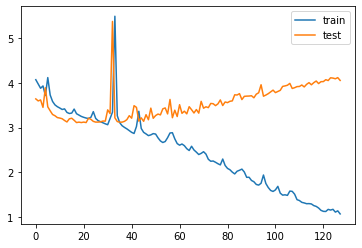

In [46]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [47]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [48]:
y_tokenizer.word_index

{'oov': 1,
 'yang': 2,
 'dan': 3,
 'hotel': 4,
 'sos': 5,
 'eos': 6,
 'dengan': 7,
 'makanan': 8,
 'di': 9,
 'pengunjung': 10,
 'juga': 11,
 'untuk': 12,
 'tempat': 13,
 'fasilitas': 14,
 'karena': 15,
 'enak': 16,
 'tidak': 17,
 'pelayanan': 18,
 'sangat': 19,
 'kamar': 20,
 'ini': 21,
 'anak': 22,
 'yaitu': 23,
 'ada': 24,
 'ramah': 25,
 'dari': 26,
 'dapat': 27,
 'memberikan': 28,
 'indah': 29,
 'sehingga': 30,
 'harga': 31,
 'nyaman': 32,
 'pemandangan': 33,
 'lengkap': 34,
 'seperti': 35,
 'kota': 36,
 'memiliki': 37,
 'luas': 38,
 'bersih': 39,
 'dekat': 40,
 'tetapi': 41,
 'serta': 42,
 'memuaskan': 43,
 'banyak': 44,
 'lokasi': 45,
 'makan': 46,
 'kolam': 47,
 'restoran': 48,
 'oleh': 49,
 'staf': 50,
 'menu': 51,
 'cepat': 52,
 'strategis': 53,
 'renang': 54,
 'terjangkau': 55,
 'bagus': 56,
 'namun': 57,
 'desain': 58,
 'selain': 59,
 'pulau': 60,
 'baik': 61,
 'bisa': 62,
 'variatif': 63,
 'standar': 64,
 'harganya': 65,
 'hari': 66,
 'steak': 67,
 'beberapa': 68,
 'itu': 69

In [49]:
# Encoding our input seq for feature vector
encoder_model = Model(inputs=enc_inp, outputs=[encoder_outputs, enc_states])

decoder_state_input_h = Input(shape=(latent_dim * 2,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim * 2))

dec_emb2= dec_embed_layer(dec_inp) 

# initial states from the previous time step
decoder_outputs2, state_h2 = dec_lstm(dec_emb2, initial_state=[decoder_state_input_h])

# Attention Inference
attention_layer = AttentionLayer()
attention_out_inference, attention_state_inference =  attention_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inference_concat = Concatenate(axis=-1)([decoder_outputs2, attention_out_inference])

# softmax for probability
decoder_outputs2 = dec_dense(decoder_inference_concat)

decoder_model = Model(
    [dec_inp, decoder_hidden_state_input, decoder_state_input_h],
    [decoder_outputs2, state_h2])

In [50]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h = decoder_model.predict([target_seq, e_out, e_h])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eos'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eos'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h = h

    return decoded_sentence

In [51]:
def sequence_to_summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sos']) and i!=target_word_index['eos']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def sequence_to_text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [52]:
pred_str = []
label_str = []
for i in range(0,8):
    pred_str.append((decode_sequence(x_tr[i].reshape(1,max_text_len))).replace('start', '').replace('end', ''))
    label_str.append((sequence_to_summary(y_tr[i])).replace('start', '').replace('end', ''))
    print("Review:",sequence_to_text(x_tr[i]))
    print("Original summary:",label_str[i])
    print("Predicted summary:",pred_str[i])
    print("\n")

1/1 [==============================] - 0s 19ms/step
Review: dengan menyenangkan kali ini ketika saya masuk ke pintu gerbang sudah nampak banyak kerumunan orang jika musim liburan candi borobudur akan luar biasa banyak pengunjungnya ini yg membuat kenyamanan sedikit berkurang pembelian tiket secara langsung cukup panjang antriannya namun untuk pembelian secara online cukup sepi sehingga ada baiknya kita beli tiketnya secara online jika tidak ingin mengantri toilet cukup banyak dan bersih tersedia juga pintu masuk dan jalur khusus untuk difabel untuk yg normal pintu pemeriksaan tiket cukup banyak sehingga tidak terlalu antri di area dalam saya pikir sebaiknya ditambah lagi tempat duduk dan area berteduh karena cukup panas sinar matahari jika sudah siang hari bus keliling tayo dan kereta mini cukup membantu supaya tidak banyak berjalan untuk pengelola ayo tingkatkan lagi fasilitasnya agar tempat wisata ini tetap menjadi destinasi pariwisata yg utama di jawa tengah candi borobudur merupaka

In [54]:
!pip install datasets
!pip install rouge_score
from datasets import load_metric

rouge = load_metric("rouge")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=56ea7eac931c5e517e3ea87ce0b4a6e2208b88bf51543c720a25faeef237ea10
  Stored in directory: /root/.cache/pip/wheels/24/55/6f/ebfc4cb176d1c9665da4e306e1705496206d08215c1acd9dde
Successfully built rouge-score


In [55]:
def rouge_matrix(pred, ref):
  result = rouge.compute(predictions=pred, references=ref)
  rouge1 = result['rouge1'].mid
  rouge2 = result['rouge2'].mid
  rougeL = result['rougeL'].mid

  return {
      "rouge1_fmeasure": round(rouge1.fmeasure, 4),
      "rouge2_fmeasure": round(rouge2.fmeasure, 4),
      "rougeL_fmeasure": round(rougeL.fmeasure, 4),
  }

In [56]:
rouge_output = rouge_matrix(pred_str, label_str)

In [57]:
print(rouge_output)

{'rouge1_fmeasure': 0.0132, 'rouge2_fmeasure': 0.0, 'rougeL_fmeasure': 0.0133}


**SEQ2SEQ MODEL BUILDING **

Split the data to TRAIN and VALIDATION sets

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras_preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

**RARE WORD ANALYSIS FOR X i.e 'text'**
* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives me the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [ ]:
thresh=1

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 0.0
Total Coverage of rare words: 0.0


In [ ]:

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 4768


**RARE WORD ANALYSIS FOR Y i.e 'summary'**
* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives me the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=1

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 0.0
Total Coverage of rare words: 0.0


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 832


We will now remove "Summary" i.e Y (both train and val) which has only _START_ and _END_

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras_preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 512, 200)     953600      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 512, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


**Start fitting the model with the data**

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=128,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/128
1/1 [==============================] - 57s 57s/step - loss: 6.7262 - val_loss: 6.5321
Epoch 2/128
1/1 [==============================] - 37s 37s/step - loss: 6.5813 - val_loss: 4.1553
Epoch 3/128
1/1 [==============================] - 34s 34s/step - loss: 4.7750 - val_loss: 3.5368
Epoch 4/128
1/1 [==============================] - 34s 34s/step - loss: 4.5711 - val_loss: 3.4499
Epoch 5/128
1/1 [==============================] - 34s 34s/step - loss: 4.1997 - val_loss: 3.1525
Epoch 6/128
1/1 [==============================] - 37s 37s/step - loss: 3.9981 - val_loss: 3.1396
Epoch 7/128
1/1 [==============================] - 34s 34s/step - loss: 3.9294 - val_loss: 2.9584
Epoch 8/128
1/1 [==============================] - 33s 33s/step - loss: 3.8026 - val_loss: 2.9116
Epoch 9/128
1/1 [==============================] - 36s 36s/step - loss: 3.7330 - val_loss: 2.9390
Epoch 10/128
1/1 [==============================] - 37s 37s/step - loss: 3.6907 - val_loss: 2.8296
Epoch 11/128
1/1 [=

**Visualize the model learning**

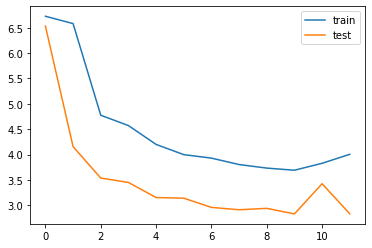

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Next, let’s build the dictionary to convert the index to word for target and source vocabulary:**

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

**We are defining a function below which is the implementation of the inference process**

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

**Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:**


In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

**Run the model over the data to see the results**

In [ ]:
print("Review:",seq2text(x_tr[0]))
print("Original summary:",seq2summary(y_tr[0]))
print("Predicted summary:",decode_sequence(x_tr[0].reshape(1,max_text_len)))
print("\n")

Review: dengan menyenangkan kali ini ketika saya masuk ke pintu gerbang sudah nampak banyak kerumunan orang jika musim liburan candi borobudur akan luar biasa banyak pengunjungnya ini yg membuat kenyamanan sedikit berkurang pembelian tiket secara langsung cukup panjang antriannya namun untuk pembelian secara online cukup sepi sehingga ada baiknya kita beli tiketnya secara online jika tidak ingin mengantri toilet cukup banyak dan bersih tersedia juga pintu masuk dan jalur khusus untuk difabel untuk yg normal pintu pemeriksaan tiket cukup banyak sehingga tidak terlalu antri di area dalam saya pikir sebaiknya ditambah lagi tempat duduk dan area berteduh karena cukup panas sinar matahari jika sudah siang hari bus keliling tayo dan kereta mini cukup membantu supaya tidak banyak berjalan untuk pengelola ayo tingkatkan lagi fasilitasnya agar tempat wisata ini tetap menjadi destinasi pariwisata yg utama di jawa tengah candi borobudur merupakan salah satu keajaiban dunia dan menjadi salah satu 

KeyError: ignored